In [2]:
import numpy as np
from numpy import sqrt as sqrt
import matplotlib.pyplot as plt
from numpy import exp, dot, einsum, sin, cos, pi

In [3]:
m_e = 0.5109989461 #(electron mass in MeV / c^2)
hbar = 6.6*10**(-16) # hbar in eV * seconds
c = 3*10**18 # speed of light in angstroms per second
prefac = ((hbar*c)**2/(2*m_e*10**6)) # prefactor of free electron dispersion
a = 1
G1 = 4*pi/(a*sqrt(3))*np.array([1, 0])
G2 = 4*pi/(a*sqrt(3))*np.array([-1/2, sqrt(3)/2])
# prefac is hbar^2/2m

# We draw the free electron dispersion overlayed on the first Brillouin zone

In [4]:
G = np.linalg.norm(G1)
bzone_area = (G**2)*sqrt(3)/2 # area of a parallelogram
k_F_squared = (1/pi)*bzone_area
k_F = sqrt(k_F_squared)
K = G/sqrt(3)

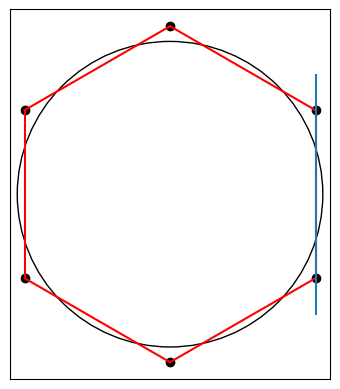

In [5]:
K_points_x = []
K_points_y = []

for n in range(0, 6):
    rot_mat = np.array([[cos(n * pi/3), sin(n * pi/3)], [-sin(n * pi/3), cos(n * pi/3)]]) 
    x, y = np.einsum("ij, j -> i", rot_mat, [0, K])
    plt.scatter(x, y, color="black")
    K_points_x.append(x)
    K_points_y.append(y)

for n in range(0, 5):
    plt.plot([K_points_x[n], K_points_x[n+1]], [K_points_y[n], K_points_y[n+1]], color="red")
plt.plot([K_points_x[5], K_points_x[0]], [K_points_y[5], K_points_y[0]], color="red")

plt.gca().add_artist(plt.Circle((0, 0), k_F, fill=False))
plt.vlines([G/2], -3, 3 )
#plt.xlim(-0.7, 0.7)
#plt.ylim(-0.7, 0.7)
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect("equal")

# Degenerate perturbation theory 

A state a $(k_1, k_2)$ in the basis of the primitive reciprocal lattice vectors will scatter to a state
$(k_1+1, k_2)$, $(k_1-1, k_2)$, $(k_1, k_2+1)$, $(k_1, k_2-1)$, $(k_1+1, k_2+1)$, $(k_1-1, k_2-1)$

In [6]:
def Hamiltonian(kx, ky, n, U, scatter_1=True, scatter_2=True, scatter_3=True):
    hamiltonian_matrix = np.zeros(((2*n+1)**2, (2*n+1)**2))
    row_idx = 0 
    Gs = []
    for i in range(-n, n+1):
        for j in range(-n, n+1):
            Gs.append(np.array([i, j]))
    for idx_1, G_1 in enumerate(Gs): 
        for idx_2, G_2 in enumerate(Gs):
            if idx_1 == idx_2:
                kprimex = kx + G1[0]*G_1[0] + G2[0]*G_1[1]
                kprimey = ky + G1[1]*G_1[0] + G2[1]*G_1[1]
                free_dispersion = prefac * (kprimex**2+kprimey**2)
                hamiltonian_matrix[idx_1, idx_2] = free_dispersion/G**2
            if scatter_1:
                if (G_1 == G_2 + np.array([1, 0])).all():
                    hamiltonian_matrix[idx_1, idx_2] = U
                if (G_1 == G_2 + [-1, 0]).all():
                    hamiltonian_matrix[idx_1, idx_2] = U
            if scatter_2: 
                if (G_1 == G_2 + [0, 1]).all():
                    hamiltonian_matrix[idx_1, idx_2] = U 
                if (G_1 == G_2 + [0, -1]).all():
                    hamiltonian_matrix[idx_1, idx_2] = U
            if scatter_3: 
                if (G_1 == G_2 + [1, 1]).all():
                    hamiltonian_matrix[idx_1, idx_2] = U 
                if (G_1 == G_2 + [-1, -1]).all():
                    hamiltonian_matrix[idx_1, idx_2] = U 

    return hamiltonian_matrix

In [7]:
k_x = G/2
N = 100 
nbands = 6
energies = np.zeros((N+1, nbands))
perturbation_energies = np.zeros(N+1)
U = 0.01
scatter_1 = True
scatter_2 = True
scatter_3 = True
for i in range(N+1):
    k_y = -K/2 + K *i/N
    energies[i, :] = np.sort(np.linalg.eigvals(Hamiltonian(k_x, k_y, 1, U, scatter_1=scatter_1, scatter_2=scatter_2, 
                                                          scatter_3=scatter_3)))[0:nbands]
    perturbation_energies[i] = prefac * (k_x**2+k_y**2)/G**2

### Finding the dispersion along the Brillouin zone boundary 

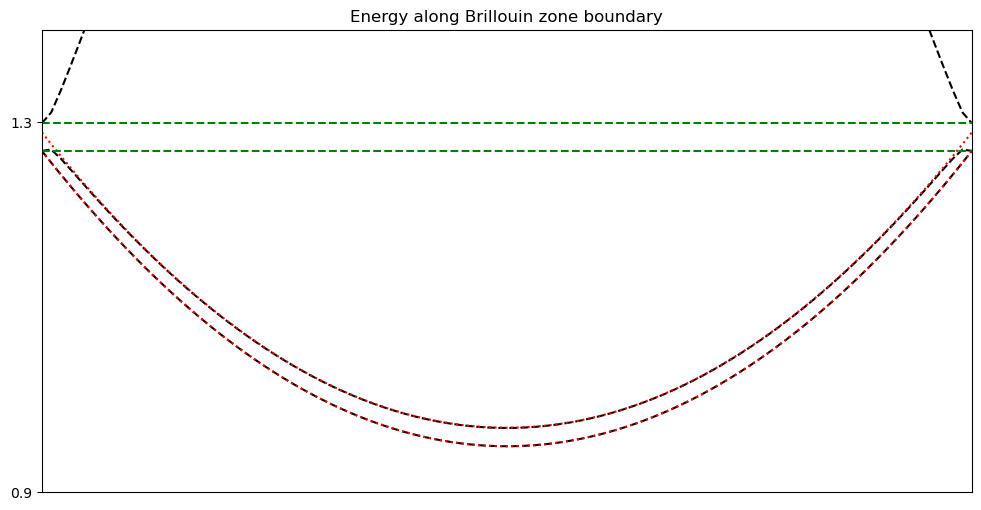

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(energies[:, 0:3], color="black", linestyle="dashed");
plt.plot(perturbation_energies + U, color="red", linestyle="dotted");
plt.plot(perturbation_energies - U, color="red", linestyle="dotted");

plt.hlines([perturbation_energies[0]-U], 0, N, linestyle="dashed", color="green")
plt.hlines([perturbation_energies[0]+2*U], 0, N, linestyle="dashed", color="green")

plt.xlim(0, N);
plt.ylim(0.9, 1.4);
plt.xticks([]);
plt.yticks([0.9, 1.3]);
plt.title("Energy along Brillouin zone boundary");
#plt.ylim(0.8, 1.5);

# Fermi surfaces with the potential

In [18]:
n = 1
N = 500
U = 0.05
eks = np.zeros((N+1, N+1, (2*n+1)**2))
kxs = np.zeros((N+1, N+1))
kys = np.zeros((N+1, N+1))
for kx_idx in range(N+1):
    kx = -K/4 + K/2*kx_idx/N
    for ky_idx in range(N+1):
        ky = -K-K/4+K/2*ky_idx/N
        h = Hamiltonian(kx, ky, n, U)
        eks[kx_idx, ky_idx, :] = np.sort(np.linalg.eigvals(h))
        kxs[kx_idx, ky_idx] = kx
        kys[kx_idx, ky_idx] = ky

In [19]:
eF = prefac*k_F_squared/G**2

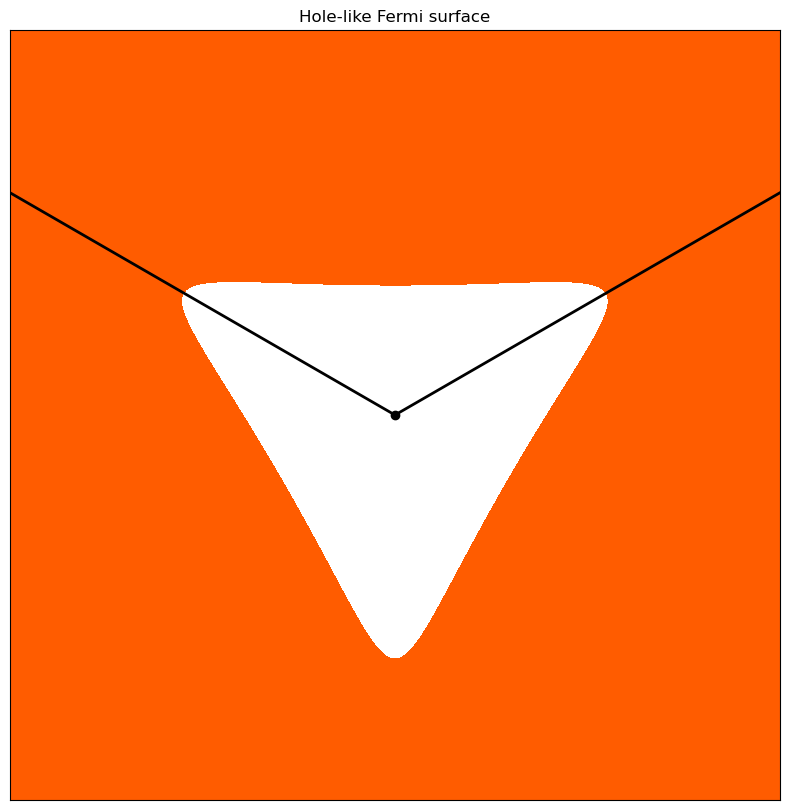

In [23]:
plt.figure(figsize=(10, 10))
plt.contourf(kxs, kys, eks[:, :, 0], [-10, eF], cmap="hot")
plt.gca().set_aspect("equal")

K_points_x = []
K_points_y = []
linewidth = 2
color = "black"
for n in range(0, 6):
    rot_mat = np.array([[cos(n * pi/3), sin(n * pi/3)], [-sin(n * pi/3), cos(n * pi/3)]]) 
    x, y = np.einsum("ij, j -> i", rot_mat, [0, K])
    plt.scatter(x, y, color="black")
    K_points_x.append(x)
    K_points_y.append(y)

for n in range(0, 5):
    pass
    plt.plot([K_points_x[n], K_points_x[n+1]], [K_points_y[n], K_points_y[n+1]], color=color, linewidth=linewidth)
plt.plot([K_points_x[5], K_points_x[0]], [K_points_y[5], K_points_y[0]], color=color, linewidth=linewidth)
plt.xlim(-K/4, K/4)
plt.ylim(-5*K/4, -3*K/4);
plt.xticks([]);
plt.yticks([]);
plt.title("Hole-like Fermi surface");